In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from splot.mapping import vba_choropleth
import mapclassify
import libpysal.weights as sw 
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran_Local, Moran
from splot.esda import lisa_cluster, plot_local_autocorrelation
import esda
from splot import esda as esdaplot
import pointpats as pp
%matplotlib inline
import matplotlib.pyplot as plt
from libpysal.cg import shapely_ext
from pointpats._deprecated_distance_statistics import K, Kenv

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
tri = pd.read_csv('tri_2020_us.csv', low_memory=False)

In [4]:
tri['geometry'] = [Point(tri.iloc[x]['13. LONGITUDE'], tri.iloc[x]['12. LATITUDE']) for x in range(len(tri))]
tri = gp.GeoDataFrame(tri, geometry = tri['geometry'])

In [5]:
#fixing the column name and format to match the counties dataframe
tri.rename(columns = {'8. ST':'state'},inplace = True)
tri.rename(columns = {'7. COUNTY':'county'},inplace = True)
tri_int = tri['county'].str.lower()
tri_final = tri['county'].str.title()
tri['county'] = tri_final
#tri

In [6]:
tri['name'] = tri['county'] + "," + " " + tri['state']

In [7]:
#Printing out all unique values for this column
tri.state.unique()

array(['TX', 'NV', 'WV', 'NY', 'PA', 'AL', 'IL', 'MN', 'MI', 'NC', 'NJ',
       'SC', 'IA', 'LA', 'IN', 'MA', 'NE', 'OH', 'OR', 'CA', 'KY', 'CT',
       'KS', 'GA', 'ME', 'MO', 'CO', 'MS', 'WA', 'AZ', 'RI', 'OK', 'WI',
       'AR', 'FL', 'TN', 'ID', 'VA', 'SD', 'PR', 'ND', 'VT', 'MD', 'GU',
       'NH', 'NM', 'AK', 'WY', 'DE', 'UT', 'MT', 'VI', 'HI', 'DC', 'MP',
       'AS'], dtype=object)

In [8]:
#removing TRI facilities in US Territories, Hawaii, and Alaska
no_PR = (tri['state'] != 'PR')
no_GU = (tri['state'] != 'GU')
no_MP = (tri['state'] != 'MP')
no_AS = (tri['state'] != 'AS')
no_VI = (tri['state'] != 'VI')
no_AK = (tri['state'] != 'AK')
no_HI = (tri['state'] != 'HI')
tri = tri[no_PR & no_GU & no_MP & no_AS & no_VI & no_AK & no_HI]

In [9]:
counties = gp.read_file('us-county-boundaries.geojson.json')

In [10]:
#counties

In [11]:
#remove the word county from the county name
#replace the county column with the new name column
counties.rename(columns = {'namelsad': 'county'}, inplace= True)
counties_int = counties['county'].str.extract(r"(\w+)", expand=True)
counties['county'] = counties_int

In [12]:
#counties

In [13]:
counties['FINAL_NAME'] = counties['county'] + "," + " " + counties['stusab']

In [14]:
#counties

In [15]:
#Seeing all counties 
counties.stusab.unique()

array(['NE', 'OH', 'MO', 'MI', 'CO', 'GA', 'MS', 'IL', 'FL', 'TX', 'PR',
       'OK', 'KY', 'IA', 'IN', 'NC', 'SD', 'KS', 'VA', 'MA', 'CA', 'LA',
       'ID', 'AK', 'NJ', 'NH', 'MD', 'NM', 'TN', 'WY', 'WV', 'AR', 'MN',
       'DE', 'WA', 'MT', 'WI', 'NY', 'HI', 'OR', 'PA', 'UT', 'ND', 'SC',
       'AL', 'NV', 'CT', 'GU', 'VT', 'RI', 'AZ', 'VI', 'AS', 'DC', 'ME',
       'MP'], dtype=object)

In [16]:
#Removing US territories, Hawaii, and Alaska
cnty_no_MP = (counties['stusab'] != 'MP')
cnty_no_GU = (counties['stusab'] != 'GU')
cnty_no_AS = (counties['stusab'] != 'AS')
cnty_no_VI = (counties['stusab'] != 'VI')
cnty_no_PR = (counties['stusab'] != 'PR')
cnty_no_AK = (counties['stusab'] != 'AK')
cnty_no_HI = (counties['stusab'] != 'HI')
counties = counties[cnty_no_MP & cnty_no_GU & cnty_no_AS & cnty_no_VI & cnty_no_PR & cnty_no_AK & cnty_no_HI]

In [17]:
print(counties.crs)

epsg:4326


In [18]:
print(tri.crs)

None


In [19]:
tri = tri.set_crs("epsg:4326")

<AxesSubplot:>

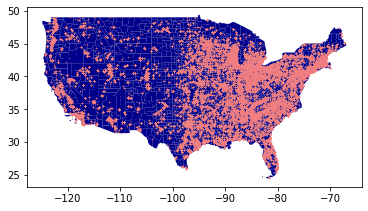

In [20]:
fig, axes=plt.subplots()
counties.plot(ax=axes, color = 'darkblue')
tri.plot(ax=axes, markersize = 0.2, color = 'lightcoral',figsize = (20,25))

In [21]:
tri_counts = gp.sjoin(counties, tri, how = 'left').groupby(['FINAL_NAME']).count()

I am getting the count of the number of TRI facilities in each county

In [22]:
tri_counts['Count'] = tri_counts['countyfp_nozero']
tri_counts = tri_counts[['Count']]

In [23]:
tri_counts

,Count
FINAL_NAME,
"Abbeville, SC",7
"Acadia, LA",13
"Accomack, VA",11
"Ada, ID",39
"Adair, IA",5
...,...
"Yuma, AZ",28
"Yuma, CO",7
"Zapata, TX",1


In [24]:
tri.rename(columns = {'103. TOTAL RELEASES':'total_releases'},inplace = True)
emissions = gp.sjoin(counties, tri, how = 'left').groupby(['FINAL_NAME']).sum()
emissions = emissions[['total_releases']]

In [25]:
tri_counts = pd.merge(tri_counts, emissions, on = 'FINAL_NAME')

In [26]:
tri_count_gdf = pd.merge(counties, tri_counts, on = 'FINAL_NAME', how='inner')

In [27]:
tri_count_gdf['count_log'] = np.log(tri_count_gdf['Count'])
#tri_count_gdf

<AxesSubplot:>

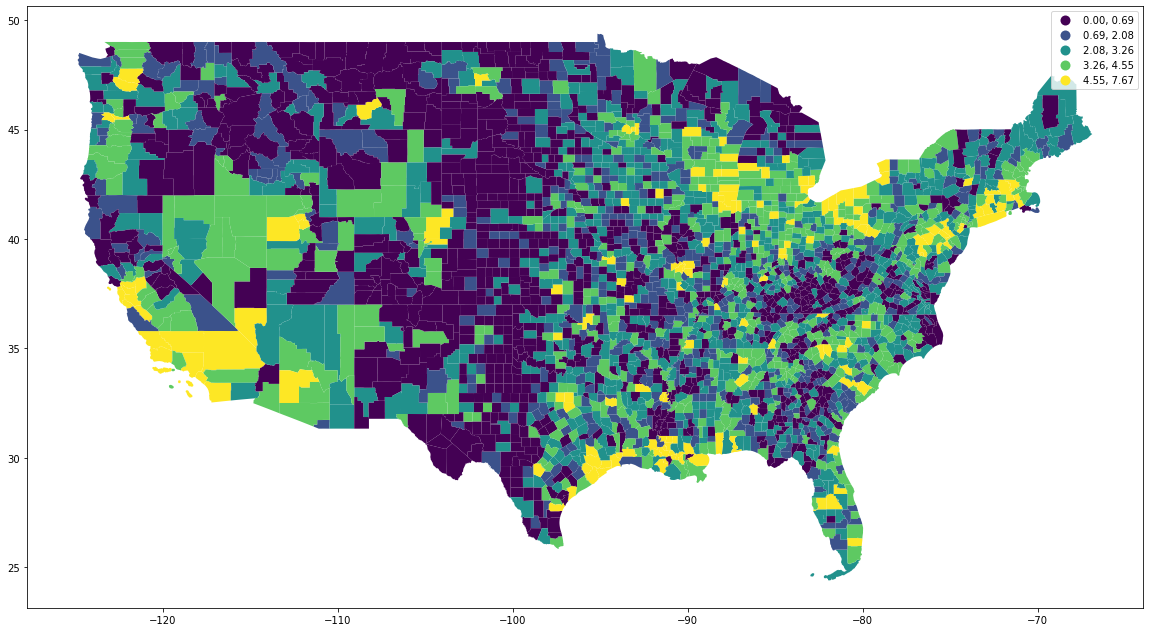

In [28]:
tri_count_gdf.plot('count_log', legend = True, scheme = 'natural_breaks', figsize = (20,25)) 

In [29]:
income = pd.read_csv('income.csv')

In [30]:
#I want to merge the tables based on their county name so I had to drop the word 'county' and the state
income['Area_name']=income.Area_name.str.rsplit(' ',0).str[0]

In [31]:
income['FINAL_NAME'] = income['Area_name'] + "," + " " + income['State']

In [32]:
merge = pd.merge(tri_count_gdf, income, on = 'FINAL_NAME', how = 'inner')

In [33]:
merge['Median_Household_Income_2019']=merge['Median_Household_Income_2019'].str.replace(',','')
merge['Count'] = merge['Count'].astype(float)
merge['count_log'] = merge['count_log'].astype(float)
merge['Median_Household_Income_2019'] = merge['Median_Household_Income_2019'].astype(float)

In [34]:
merge['square_miles'] = (merge['aland']+merge['awater'])*3.86102e-7

In [35]:
merge['density'] = merge['Count']/merge['square_miles']

In [36]:
merge['density_log'] = np.log(merge['density'])

In [37]:
max_count = merge[merge['Count']==merge['Count'].max()]

<AxesSubplot:>

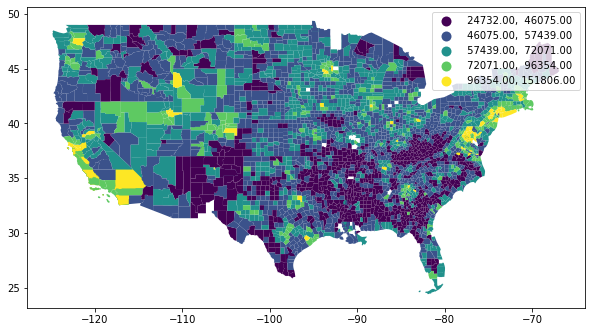

In [38]:
merge.plot('Median_Household_Income_2019', legend = True, scheme = 'NaturalBreaks', figsize = (10,15))

In [39]:
merge['scaled_density'] = merge['density']*100

<AxesSubplot:>

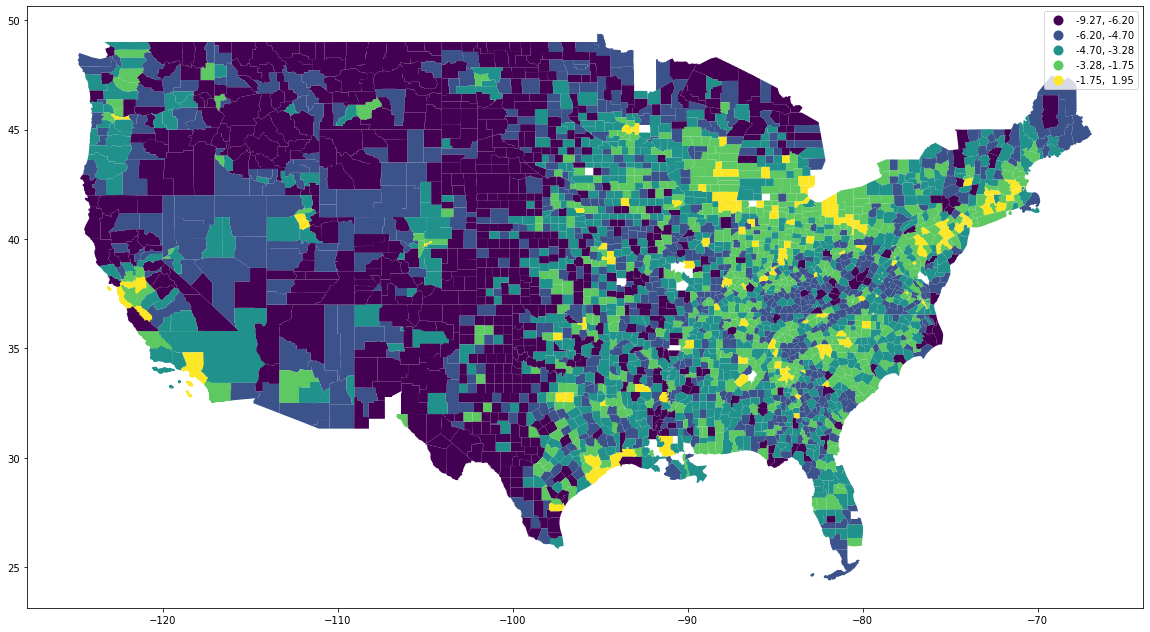

In [40]:
merge.plot('density_log', legend = True, scheme = 'natural_breaks', figsize = (20,15))

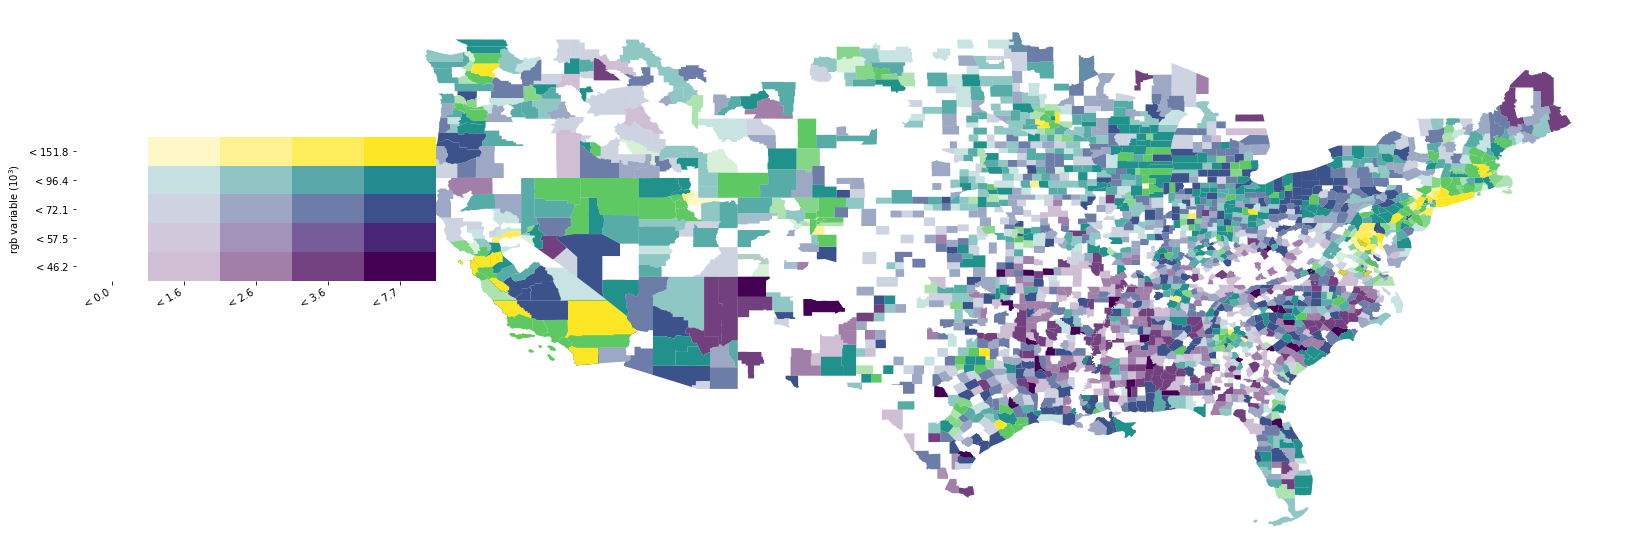

In [41]:
x = merge['Median_Household_Income_2019']
y = merge['count_log']
fig, ax = plt.subplots(figsize=(25,10))
vba_choropleth(x, y, merge, cmap = 'viridis',
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='natural_breaks', k=5),
               legend=True, ax=ax)
plt.show()

In [42]:
qw = sw.Queen.from_dataframe(merge)

In [77]:
qw.transform = 'r'
z = merge['Count']
counts = Moran(z,qw)
print(counts.I, counts.p_sim)

0.47730622963439523 0.001


In [44]:
income_rank = []

In [45]:
for income in merge['Median_Household_Income_2019']:
    if income <= 46000:
        income_rank.append(1)
    elif 46000 < income <= 57000:
        income_rank.append(2)
    elif 57000 < income <= 71000:
        income_rank.append(3)
    elif 71000 < income <= 96000:
        income_rank.append(4)
    else:
        income_rank.append(5)

In [46]:
merge['income_rank'] = income_rank

In [47]:
y = merge.groupby(['income_rank']).Count.sum().reset_index()

In [48]:
y

,income_rank,Count
0,1,8090.0
1,2,27309.0
2,3,37118.0
3,4,27650.0
4,5,11575.0


In [49]:
x = [1,2,3,4,5]

Text(0.5, 1.0, 'Total Number of TRI Facilities for Each Income Rank')

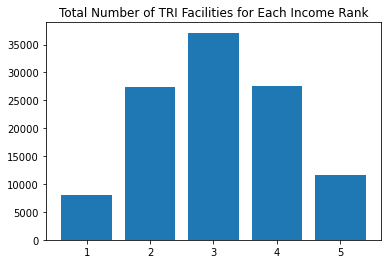

In [50]:
plt.bar(x,y['Count'])
plt.title('Total Number of TRI Facilities for Each Income Rank')

Text(0.5, 1.0, 'Total Number of Counties in Each Income Rank')

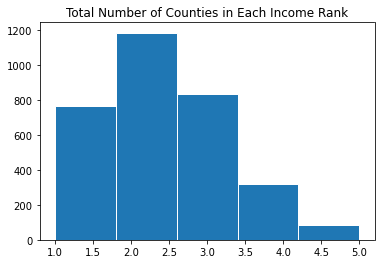

In [51]:
plt.hist(merge['income_rank'], bins = 5, edgecolor = 'white')
plt.title('Total Number of Counties in Each Income Rank')

There are fewer TRI facilities in the counties with higher income, but there are also fewer higher income counties overall

This is a bar graph showing the distribution of the number of TRI facilities based on income- x is the category for income and the y axis shows the total number of TRI facilities in that group

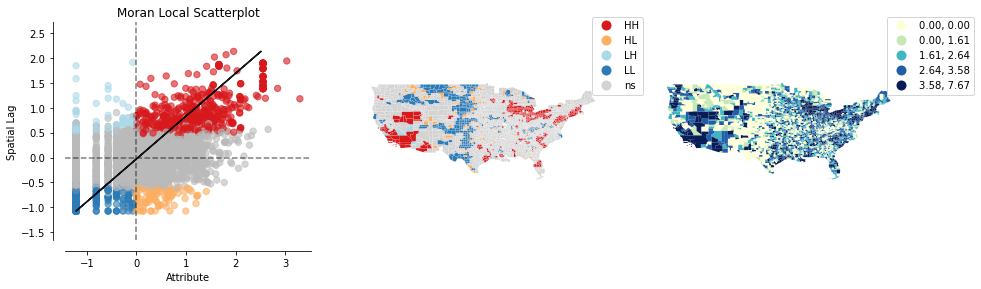

In [79]:
queen_locali = esda.moran.Moran_Local(z, qw)
lisa = esda.Moran_Local(merge['count_log'], qw)
esdaplot.plot_local_autocorrelation(lisa, merge, 'count_log');

In [53]:
merge['emissions_log'] = np.log(merge['total_releases'])

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
merge.replace([np.inf, -np.inf], 0, inplace=True)

<AxesSubplot:>

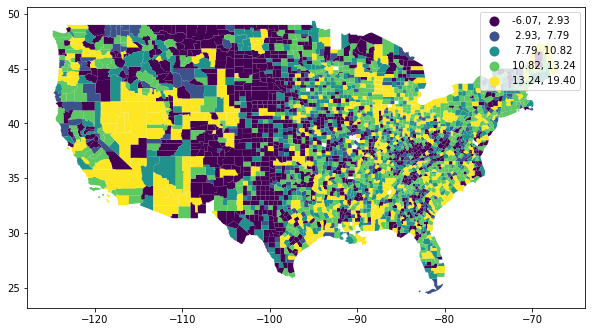

In [55]:
merge.plot('emissions_log', legend = True, scheme = 'NaturalBreaks', figsize = (10,15))

In [57]:
x = merge['emissions_log']
emissions = Moran(x,qw)
print(emissions.I, emissions.p_sim)

0.2701185574678374 0.001


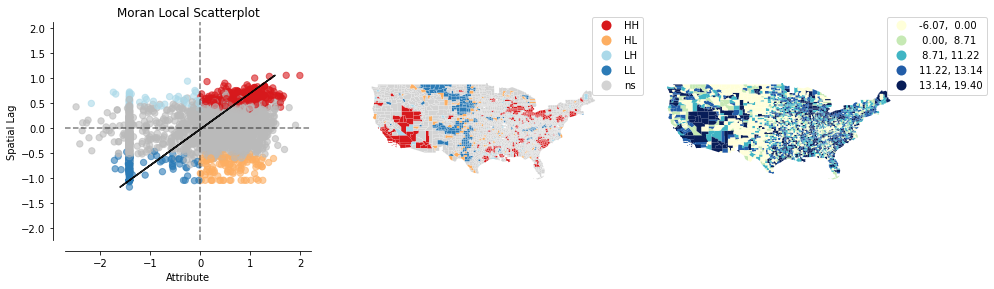

In [58]:
queen_locali = esda.moran.Moran_Local(x, qw)
lisa = esda.Moran_Local(merge['emissions_log'], qw)
esdaplot.plot_local_autocorrelation(lisa, merge, 'emissions_log');

In [59]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

In [60]:
x = merge[['count_log']]
y = merge[['Median_Household_Income_2019']]

In [61]:
moran_bv = Moran_BV(y, x, qw)

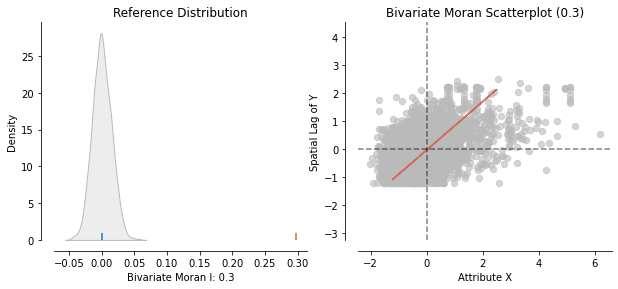

In [62]:
plot_moran_bv(moran_bv)
plt.show()

In [63]:
moran_loc_bv = Moran_Local_BV(x, y, qw)

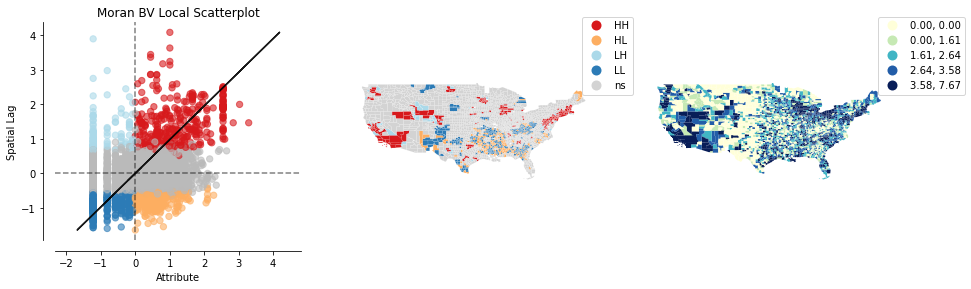

In [64]:
plot_local_autocorrelation(moran_loc_bv, merge, 'count_log')
plt.show()

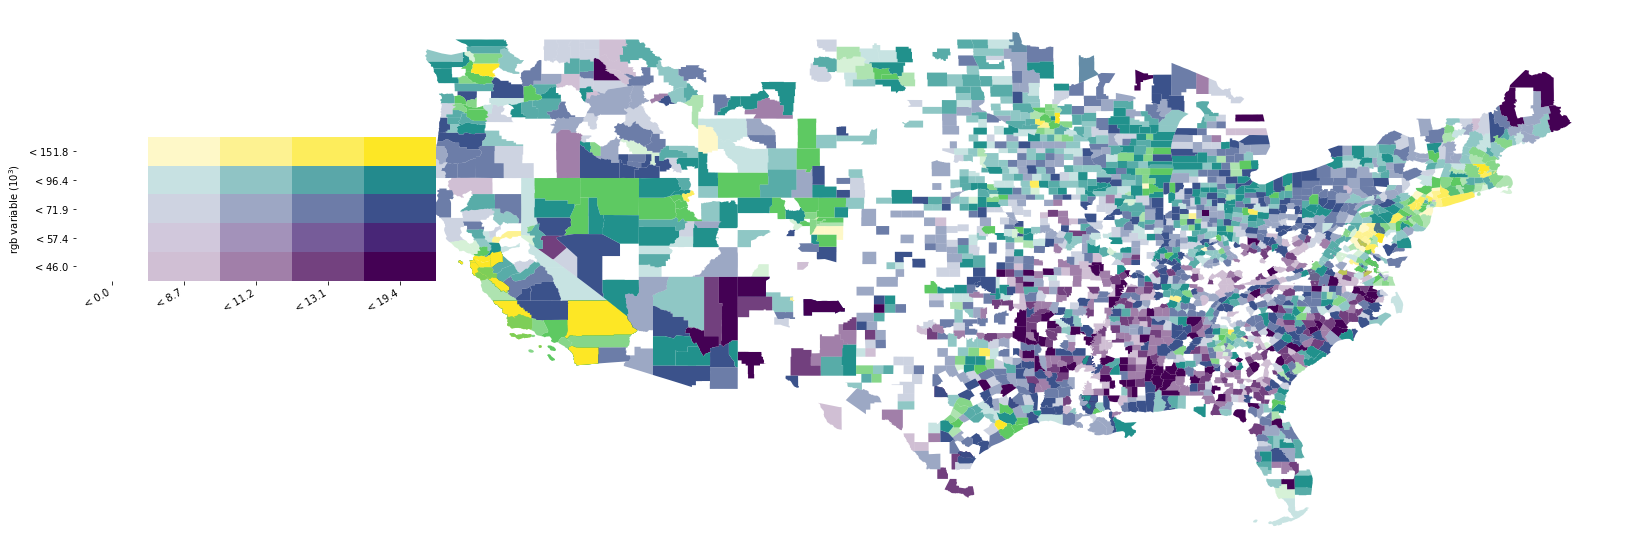

In [65]:
x = merge['Median_Household_Income_2019']
y = merge['emissions_log']
fig, ax = plt.subplots(figsize=(25,10))
vba_choropleth(x, y, merge, cmap = 'viridis',
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='natural_breaks', k=5),
               legend=True, ax=ax)
plt.show()

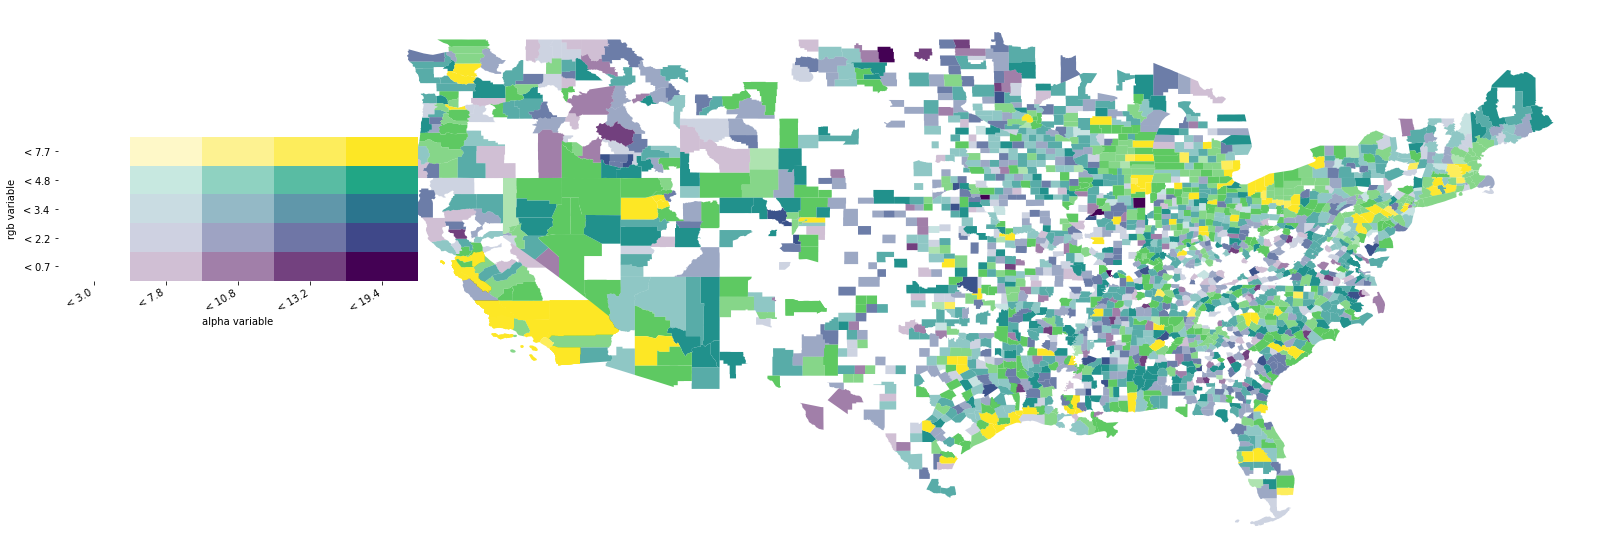

In [81]:
x = merge['count_log']
y = merge['emissions_log']
fig, ax = plt.subplots(figsize=(25,10))
vba_choropleth(x, y, merge, cmap = 'viridis',
               alpha_mapclassify=dict(classifier='natural_breaks', k=5),
               rgb_mapclassify=dict(classifier='natural_breaks', k=5),
               legend=True, ax=ax)
plt.show()

In [68]:
y = merge.groupby(['income_rank']).total_releases.sum().reset_index()

Text(0.5, 1.0, 'Total Emissions for Each Income Rank')

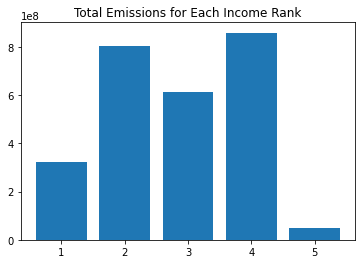

In [71]:
x = [1,2,3,4,5]
plt.bar(x,y['total_releases'])
plt.title('Total Emissions for Each Income Rank')

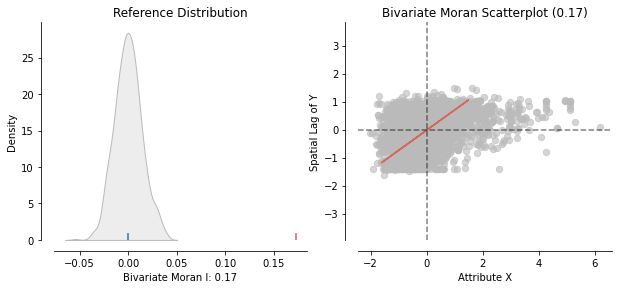

In [72]:
x = merge[['emissions_log']]
y = merge[['Median_Household_Income_2019']]
moran_bv = Moran_BV(y, x, qw)
plot_moran_bv(moran_bv)
plt.show()

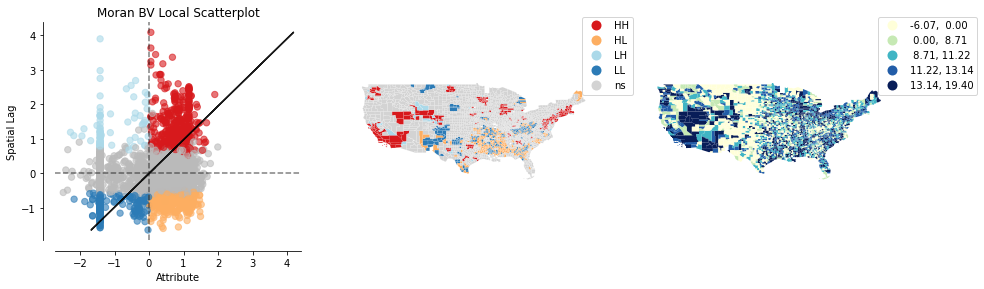

In [73]:
moran_loc_bv = Moran_Local_BV(x, y, qw)
plot_local_autocorrelation(moran_loc_bv, merge, 'emissions_log')
plt.show()

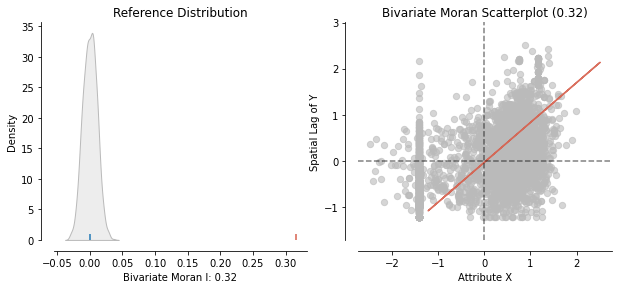

In [75]:
x = merge[['emissions_log']]
y = merge[['count_log']]
moran_bv = Moran_BV(x, y, qw)
plot_moran_bv(moran_bv)
plt.show()

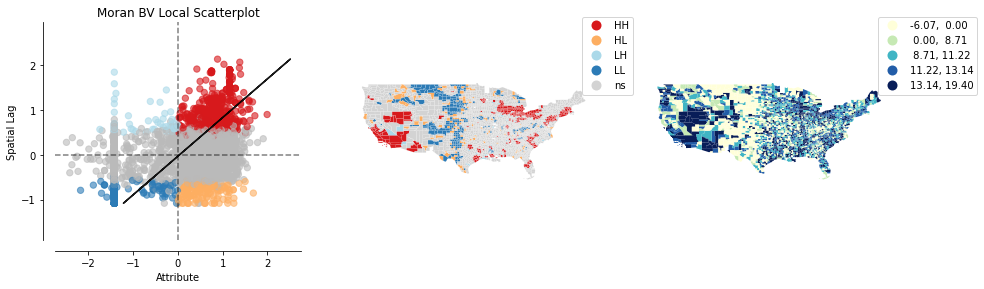

In [76]:
moran_loc_bv = Moran_Local_BV(x, y, qw)
plot_local_autocorrelation(moran_loc_bv, merge, 'emissions_log')
plt.show()